<h1>This notebook implements Neural Style Transfer preserving the original colours</h1>

The following papers are implemented: <br>
1. <a href="https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf">Image Style Transfer Using Convolutional Neural Networks</a> <br>-- Leon A. Gatys, Alexander S. Ecker, Matthias Bethge

2. <a href="https://arxiv.org/pdf/1606.05897.pdf">Preserving Color in Neural Artistic Style Transfer</a> <br>-- Leon A. Gatys, Matthias Bethge, Aaron Hertzmann, Eli Shechtman

In [ ]:
  import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import matplotlib.pyplot as plt
import glob as glob
import numpy as np
from PIL import Image
import IPython.display as display
import cv2
import skimage

<h2>Loading the Content and Style Images</h2>

In [ ]:
content_path = tf.keras.utils.get_file('Landscape_with_lake.jpg', 'https://unsplash.com/photos/ZNkvxIPPVeE/download?force=true&w=640')
style_path =  tf.keras.utils.get_file('vangogh_self_1887_2.jpg', 'https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-sk-a-3262.jpg?w=600&dpr=1&fit=default&crop=default&q=65&vib=3&con=3&usm=15&bg=F4F4F3&ixlib=js-2.2.1&s=1e5fd718ce15092325c9c4979e474936')
#tf.keras.utils.get_file('vangogh_self_1887.jpg','https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-self-portrait.jpg?w=600&dpr=1&fit=default&crop=default&q=65&vib=3&con=3&usm=15&bg=F4F4F3&ixlib=js-2.2.1&s=938342d2216db7ba9de455bc7cb383f5')
#tf.keras.utils.get_file('vangogh_self_strawhat.jpg', 'https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-dt150253.jpg?w=600&dpr=1&fit=default&crop=default&q=65&vib=3&con=3&usm=15&bg=F4F4F3&ixlib=js-2.2.1&s=ca438965724b542a4273edd52cb5a368')
#tf.keras.utils.get_file('vangogh_postman.jpg', 'https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-pd46-1007rob.jpg?w=600&dpr=1&fit=default&crop=default&q=65&vib=3&con=3&usm=15&bg=F4F4F3&ixlib=js-2.2.1&s=dbf0adf9d97a739dda44d7d4a331d615') 
#tf.keras.utils.get_file('vangogh_starrynight1.jpg','https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-snvgrob.jpg?w=800&dpr=1&fit=default&crop=default&q=65&vib=3&con=3&usm=15&bg=F4F4F3&ixlib=js-2.2.1&s=53dc70eb2bded647a1b209f798716782') 
#tf.keras.utils.get_file('vangogh_starry_sky_over_rhone.jpg','https://upload.wikimedia.org/wikipedia/commons/thumb/9/94/Starry_Night_Over_the_Rhone.jpg/1280px-Starry_Night_Over_the_Rhone.jpg') 
#tf.keras.utils.get_file('vangogh_p2  .jpg','https://img.rawpixel.com/s3fs-private/rawpixel_images/website_content/pdvangogh-sk-a-3262.jpg?w=600&dpr=1&fit=default&crop=default&q=65&vib=3&con=3&usm=15&bg=F4F4F3&ixlib=js-2.2.1&s=1e5fd718ce15092325c9c4979e474936') 
#tf.keras.utils.get_file('vangogh_wheatfield.jpg','https://cdn8.openculture.com/2018/07/08215146/Van-Gogh-Wheatfield-with-Crows.jpg')
#tf.keras.utils.get_file('cupid_nypl.jpg','https://unsplash.com/photos/R5oumqz_lhY/download?force=true&w=1920')

163840/157135 [===============================] - 0s 0us/step


In [ ]:
max_dim = 512
n_ch = 3

<h2>Image Loader</h2>

In [ ]:
from skimage import io
from skimage import transform
def load_image(image_path):
  img = skimage.io.imread(image_path)
  img = skimage.img_as_float32(img)
  shape = np.array(img.shape[:-1])
  long_dim = np.max(shape)
  scale = (max_dim/long_dim).astype(np.float32)
  #print(scale,shape)
  new_shape = tuple(np.multiply(shape,scale).astype(np.int32))
  #print(new_shape)
  resized_img = skimage.transform.resize(img, new_shape)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img

(1, 307, 512, 3) (1, 511, 406, 3)


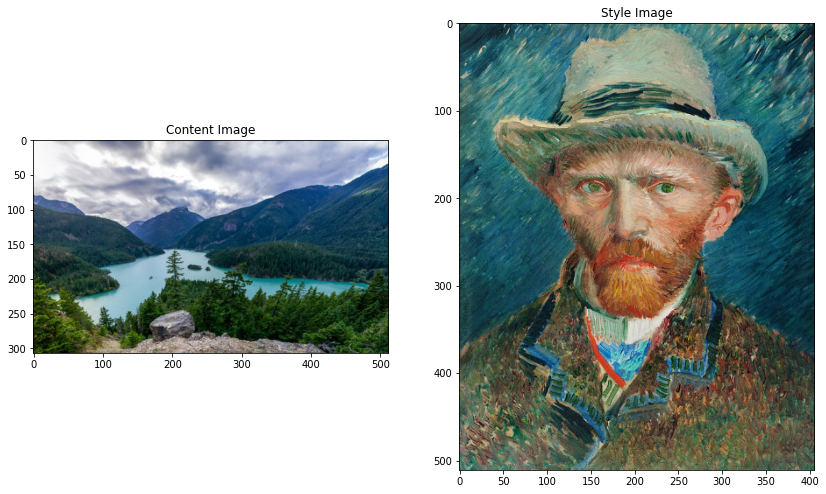

In [ ]:
content_image = load_image(content_path)
style_image = load_image(style_path)
print(content_image.shape, style_image.shape)

plt.figure(figsize=(14,14))
plt.subplot(1, 2, 1)
plt.title('Content Image')
plt.imshow(content_image[0])

plt.subplot(1, 2, 2)
plt.title('Style Image')
plt.imshow(style_image[0])

<h2>Defining VGG Layers</h2>

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

content_layers = ['block4_conv2', 'block5_conv2']

#style_layers = ['block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block4_conv1', 'block4_conv2', 'block5_conv1', 'block5_conv2']

#content_layers = ['block5_conv4']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers_ext(layers):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layers]
  model = tf.keras.Model([vgg.input], outputs)
  return model

<h2>Model</h2>

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers_ext(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
#results = extractor(tf.constant(content_image))

<h2>Gram Matrix Function</h2>

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [ ]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
lr = 10#0.02
opt = tf.optimizers.Adam(learning_rate=lr, beta_1=0.99, epsilon=1e-1)

<h2>Style and Content losses</h2>

In [ ]:
def style_content_loss(outputs, style_targets1, content_targets1):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    #print(tf.shape(content_outputs['block5_conv2']), tf.shape(content_targets1['block5_conv2']))
    #print(content_outputs['block5_conv2'], content_targets1['block5_conv2'])
    #print()
    #print(style_outputs['block1_conv1'], style_targets1['block1_conv1'])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets1[name])**2) for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    #tf.print("Style Loss = ", style_loss)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets1[name])**2) for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    #tf.print("Content Loss = ", content_loss)
    loss = style_loss + content_loss
    return loss

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return Image.fromarray(tensor)

In [ ]:
def train_step(image, style_targets, content_targets):
  with tf.GradientTape() as tape:
    outputs = extractor(image)

    loss = style_content_loss(outputs, style_targets, content_targets)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

<h2>Train Function</h2>

In [ ]:
def train(image, style_targets, content_targets, epochs, steps_per_epoch):
  import time
  start = time.time()

  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image, style_targets, content_targets)
      print("=", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

  end = time.time()
  print("Total time: {:.1f}".format(end-start))

<h2>Colour Transfer</h2>

In [ ]:
#Functions to transfer colour values from original images to stylized ones

def image_stats(image):
  (l, a, b) = cv2.split(image)
  (lMean, lStd) = (l.mean(), l.std())
  (aMean, aStd) = (a.mean(), a.std())
  (bMean, bStd) = (b.mean(), b.std())
  return (lMean, lStd, aMean, aStd, bMean, bStd)
 
def color_transfer(source, target, clip=True, preserve_paper=True):
	source = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
	target = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")

	(lMeanSrc, lStdSrc, aMeanSrc, aStdSrc, bMeanSrc, bStdSrc) = image_stats(source)
	(lMeanTar, lStdTar, aMeanTar, aStdTar, bMeanTar, bStdTar) = image_stats(target)

	(l, a, b) = cv2.split(target)
	l -= lMeanTar
	a -= aMeanTar
	b -= bMeanTar

	if preserve_paper:
		l = (lStdTar / lStdSrc) * l
		a = (aStdTar / aStdSrc) * a
		b = (bStdTar / bStdSrc) * b
	else:
		l = (lStdSrc / lStdTar) * l
		a = (aStdSrc / aStdTar) * a
		b = (bStdSrc / bStdTar) * b

	l += lMeanSrc
	a += aMeanSrc
	b += bMeanSrc

	l = np.clip(l, 0, 255)
	a = np.clip(a, 0, 255)
	b = np.clip(b, 0, 255)

	transfer = cv2.merge([l, a, b])
	transfer = cv2.cvtColor(transfer.astype("uint8"), cv2.COLOR_LAB2BGR)
	
	return transfer

<h2>Luminance Transfer</h2>

In [ ]:
#Luminance-only transfer from original images to stylized counterparts

def luminance_transfer(content_image, styled_image):
  content_yuv = cv2.cvtColor(content_image, cv2.COLOR_BGR2YUV)
  stylized_yuv = cv2.cvtColor(styled_image, cv2.COLOR_BGR2YUV)
  _, ch2, ch3 = cv2.split(content_yuv)
  ch1, _, _ = cv2.split(stylized_yuv)
  ch1 = (skimage.transform.resize(ch1, ch2.shape)*255).astype(np.uint8)
  merged = cv2.merge((ch1, ch2, ch3))
  lum_transf = (cv2.cvtColor(merged, cv2.COLOR_YUV2BGR)/255).astype(np.float32)
  return lum_transf

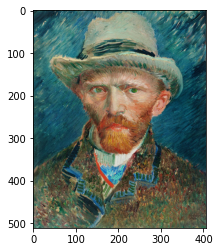

In [ ]:
style_img = np.array(tensor_to_image(style_image))
plt.imshow(style_img)

<h2>Style and Content Weights</h2>

In [ ]:
style_weight=5e-2#1e-3#8e-2
content_weight=5e2#1e2#5e5

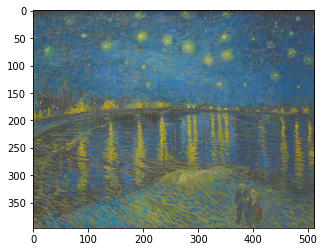

In [ ]:
content_img_np = np.array(tensor_to_image(content_image))
style_img_mat_train = color_transfer(content_img_np, style_img)
plt.imshow(style_img_mat_train)
style_img_mat_train = tf.convert_to_tensor(style_img_mat_train/255.0, dtype=tf.float32)
style_img_mat_train = style_img_mat_train[tf.newaxis, :]

In [ ]:
image = tf.Variable(content_image)

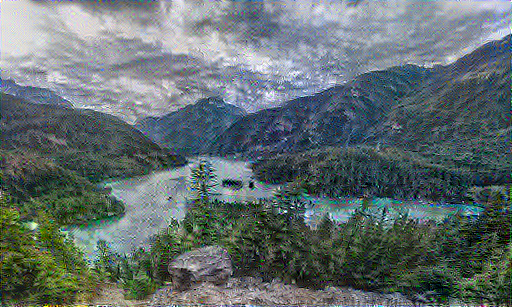

Train step: 2000
Total time: 205.6


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']
train(image, style_targets, content_targets, epochs=20, steps_per_epoch=100)

<h2>Downloading and displaying Test Image </h2>

81920/79776 [==============================] - 0s 1us/step
512


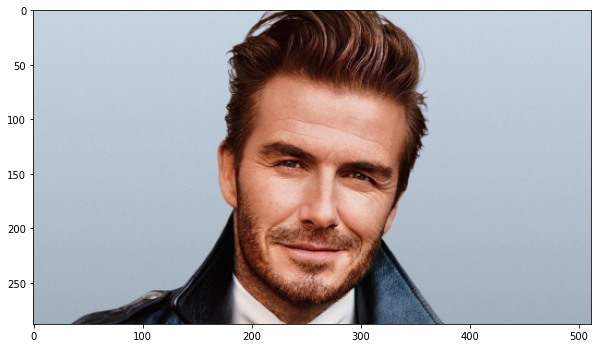

In [ ]:
test_img_path = tf.keras.utils.get_file("Beckham1.jpg", 'https://www.theargus.co.uk/resources/images/10966467?type=responsive-gallery-fullscreen')
max_dim = 512#np.max(cv2.imread(test_img_path, cv2.IMREAD_UNCHANGED).shape[:-1])
print(max_dim)
test_img = load_image(test_img_path)
plt.figure(figsize=(10,10))
plt.imshow(test_img[0])

<h2>Running Style Transfer on Test Image</h2>

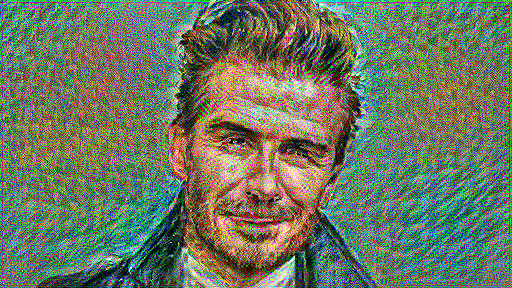

Train step: 2000
Total time: 204.5


In [ ]:
test_style_targets = extractor(style_image)['style']
test_content_targets = extractor(test_img)['content']
test_image = tf.Variable(test_img)
train(test_image, test_style_targets, test_content_targets, epochs=20, steps_per_epoch=100)

<h2>Applying Luminance Transfer to Stylized Image</h2>

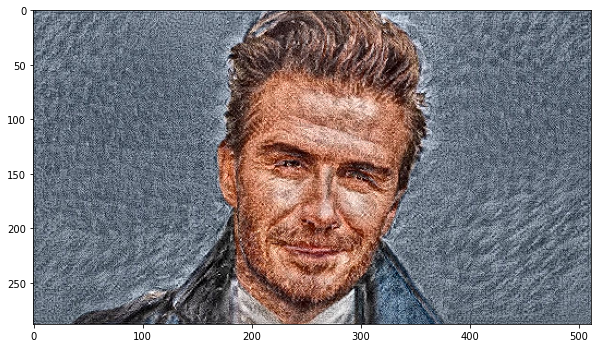

In [ ]:
test_img_np = np.array(tensor_to_image(test_img))
img_ext = np.array(tensor_to_image(test_image))
stylized_img_cmapd = luminance_transfer(test_img_np, img_ext)
plt.figure(figsize=(10,10))
plt.imshow(stylized_img_cmapd)

(576, 1024)
(576, 1024, 3)


True

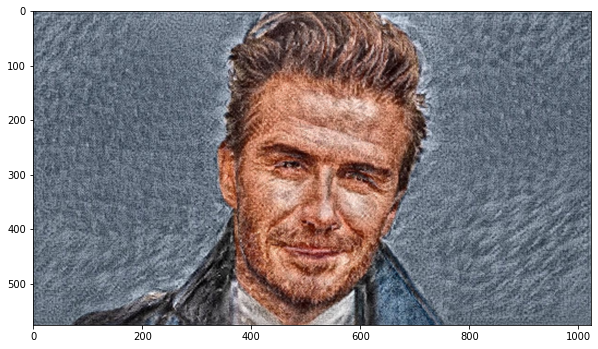

In [ ]:
upfactored=tuple(np.array(stylized_img_cmapd.shape[:-1])*2)
print(upfactored)
out_img_transf = skimage.transform.resize(stylized_img_cmapd, upfactored)
out_img_original = skimage.transform.resize(img_ext, upfactored).astype(np.float32)
plt.figure(figsize=(10,10))
plt.imshow(out_img_transf)
print(out_img_transf.shape)
out_img_transf = (cv2.cvtColor(out_img_transf, cv2.COLOR_BGR2RGB)*255).astype(np.int64)
out_img_original = (cv2.cvtColor(out_img_original, cv2.COLOR_BGR2RGB)*255).astype(np.int64)
cv2.imwrite('Beckham_vangogh_self1887_2.jpg',out_img_transf)
cv2.imwrite('Beckham_vangogh_self1887_2_original.jpg',out_img_original)